In [1]:
import os
import json
import yaml
from collections import defaultdict
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as mpatch
import matplotlib
%matplotlib inline

from results_plotter import read_exp_results as read_exp

In [2]:
def get_im_vol_list(target_volunteers, num_images):
    im_vol_list = []
    for i in range(num_images):
        x = target_volunteers[target_volunteers[:,0] == i, -1].int().detach().numpy()
        num_boxes = x.shape[0]
        vol_per_im = []
        for j in range(num_boxes):
            vol_per_im.append(x[j])
        im_vol_list.append(vol_per_im)
    return im_vol_list

In [3]:
# rel_path = os.path.join(os.curdir, 'runs', 'train')
rel_path = os.path.join('/Users/gs0029/onedrive/University of Surrey/Yin, Camellia (PG R - Computer Science) - runs', 'train')

In [4]:
metadata_filename = 'results_metadata.json'
metadata = json.load(open(metadata_filename, 'r'))
metadata

{'baseline': {'name': 'yolo', 'exp_id': 218},
 'contribution': {'name': 'cyolo', 'exp_id': 236}}

In [5]:
exp_no = metadata['baseline']['exp_id']
exp_results = read_exp(exp_no, rel_path = rel_path)
exp_results.keys()

dict_keys(['results', 'hyp', 'opt', 'pred', 'cm'])

In [6]:
data_yaml_filename = exp_results['opt']['data']
data_dict = yaml.safe_load(open(data_yaml_filename, 'r'))
data_path = data_dict['path']
train_path = os.path.join(data_path, data_dict['train'])
val_path = os.path.join(data_path, data_dict['val'])
test_path = os.path.join(data_path, data_dict['test'])
data_dict

{'path': 'datasets',
 'train': 'iid-tvt/images/train',
 'val': 'iid-tvt/images/val',
 'test': 'iid-tvt/images/test',
 'nc': 2,
 'names': ['bone-loss', 'dental-caries']}

In [7]:
class_names = data_dict['names']
class_name_abbr_map = {'bone-loss': 'BL', 'dental-caries': 'DC'}

In [8]:
def get_im_boxes_map(preds):
    im_boxes_map = defaultdict(list)
    for pred in tqdm(preds):
        im_id = pred['image_id']
        im_boxes_map[im_id].append({k:v for k, v in pred.items() if k != 'image_id'})
    im_boxes_map = dict(im_boxes_map)
    im_names = list(sorted(im_boxes_map))
    return im_boxes_map, im_names

In [9]:
exp_no = metadata['baseline']['exp_id']
exp_results = read_exp(exp_no, rel_path = rel_path)
yolo_preds = exp_results['pred']
yolo_im_boxes_map, yolo_im_names = get_im_boxes_map(yolo_preds)

  0%|          | 0/21996 [00:00<?, ?it/s]

In [10]:
exp_no = metadata['contribution']['exp_id']
exp_results = read_exp(exp_no, rel_path = rel_path)
cyolo_preds = exp_results['pred']
cyolo_im_boxes_map, cyolo_im_names = get_im_boxes_map(cyolo_preds)

  0%|          | 0/24000 [00:00<?, ?it/s]

In [11]:
vol_names = ['Camellia', 'Conghui', 'HaoWen', 'Xiongjie']
vol_name_id_map = dict(zip(vol_names, range(1, 1+len(vol_names))))
im_prefs = list(sorted({x['image_id'].split('.')[0] for x in yolo_preds}))
vol_entries = []
for v in vol_names:
    labels_path = os.path.join(data_dict['path'], 'master', 'labels', v)
    for pref in im_prefs:
        label_file_path = os.path.join(labels_path, pref+'.txt')
        try:
            with open(label_file_path, 'r') as f:
                lines = [tuple(map(lambda x: round(float(x), 3), x.strip().split())) for x in f.readlines()]
            for c, x, y, w, h in lines:
                c = int(c)
                entry = {'image_id': pref,
                         'category_id': c,
                         'bbox': [x, y, w, h],
                         'volunteer': v}
                vol_entries.append(entry)
        except FileNotFoundError:
            print(label_file_path, 'not found')
            entry = {'image_id': pref,
                     'category_id': None,
                     'bbox': None,
                     'volunteer': v}
            vol_entries.append(entry)

vol_im_boxes_map, vol_im_names = get_im_boxes_map(vol_entries)

datasets/master/labels/Camellia/Unknown-X-20200108-120416-XDI5AZK8EAY1-3.txt not found
datasets/master/labels/Camellia/Unknown-X-20200108-162424-XJTVFFN98KRL-3.txt not found
datasets/master/labels/Camellia/Unknown-X-20200206-103145-XGYENCEPQD41-3.txt not found
datasets/master/labels/Conghui/Unknown-X-20200108-120416-XDI5AZK8EAY1-3.txt not found
datasets/master/labels/Conghui/Unknown-X-20200108-162424-XJTVFFN98KRL-3.txt not found
datasets/master/labels/Conghui/Unknown-X-20200206-103145-XGYENCEPQD41-3.txt not found
datasets/master/labels/HaoWen/Unknown-X-20200108-120416-XDI5AZK8EAY1-3.txt not found
datasets/master/labels/HaoWen/Unknown-X-20200108-162424-XJTVFFN98KRL-3.txt not found
datasets/master/labels/HaoWen/Unknown-X-20200206-103145-XGYENCEPQD41-3.txt not found
datasets/master/labels/Xiongjie/IS20191125_105634_0062_000039C9.txt not found
datasets/master/labels/Xiongjie/Unknown-X-20200108-120416-XDI5AZK8EAY1-3.txt not found
datasets/master/labels/Xiongjie/Unknown-X-20200108-162424-XJT

  0%|          | 0/233 [00:00<?, ?it/s]

In [12]:
exp_name = 'Jonathan'
im_prefs = list(sorted({x['image_id'].split('.')[0] for x in yolo_preds}))
exp_entries = []
labels_path = os.path.join(data_dict['path'], 'master', 'labels', exp_name)
for pref in im_prefs:
    label_file_path = os.path.join(labels_path, pref+'.txt')
    try:
        with open(label_file_path, 'r') as f:
            lines = [tuple(map(lambda x: round(float(x), 3), x.strip().split())) for x in f.readlines()]
        for c, x, y, w, h in lines:
            c = int(c)
            entry = {'image_id': pref,
                     'category_id': c,
                     'bbox': [x, y, w, h]}
            exp_entries.append(entry)
    except FileNotFoundError:
        print(label_file_path, 'not found')
        entry = {'image_id': pref,
                 'category_id': None,
                 'bbox': None}
        exp_entries.append(entry)
exp_im_boxes_map, exp_im_names = get_im_boxes_map(exp_entries)

  0%|          | 0/94 [00:00<?, ?it/s]

In [32]:
pref = 'IS20191125_105634_0062_000039C9'
boxes = exp_im_boxes_map[pref]
im_filepath = os.path.join(data_dict['path'], data_dict['val'], pref+'.Camellia.jpg')
img = mpimg.imread(im_filepath)
ht, wd, _ = img.shape

In [33]:
wd, ht

(941, 724)

In [13]:
def get_im_boxes(im_name, mode):
    if mode == 'y':
        return yolo_im_boxes_map[im_name]
    elif mode == 'cy':
        return cyolo_im_boxes_map[im_name]
    elif mode == 'v':
        return vol_im_boxes_map[im_name.split('.')[0]]
    elif mode == 'e':
        return exp_im_boxes_map[im_name.split('.')[0]]

In [87]:
def plot_predboxes_per_radiograph(im_filepath, im_boxes, ax, conf_thres, mode):
    img = mpimg.imread(im_filepath)
    ht, wd, _ = img.shape

    ax.axis('off')
    img_plot = ax.imshow(img)

    box_linewidth = 2
    box_color_map = {'bone-loss': 'r', 'dental-caries': 'y'}
    use_abbr_labels = True
    text_on_box_color = 'w'
    text_on_box_fontsize = 10
    text_on_box_ha = 'left'
    text_on_box_va = 'center'

    for im_box in im_boxes:
        box_class = im_box['category_id']
        bbox = im_box['bbox']
        if box_class is None or bbox is None:
            print(im_filepath, 'has not been tagged by volunteer', im_box['volunteer'], '. Ignoring...')
            continue
        score_mode = True
        vol_mode = False
        try:
            box_score = im_box['score']
        except KeyError:
            score_mode = False
        try:
            vol_name = im_box['volunteer']
            vol_id = vol_name_id_map[vol_name]
            vol_mode = True
        except KeyError:
            pass
        text_on_box = class_names[box_class]
        if score_mode:
            if box_score < conf_thres[text_on_box]:
                continue
        box_color = box_color_map[text_on_box]
        if use_abbr_labels:
            text_on_box = class_name_abbr_map[text_on_box]
        if score_mode:
            text_on_box = f'{text_on_box} ({int(box_score*100)}%)'
        if vol_mode:
            text_on_box = f'{text_on_box} (V{vol_id})'
        x, y, w, h = bbox
        if mode in {'v', 'e'}:
            x, y, w, h = x*wd, y*ht, w*wd, h*ht
            px, py, pw, ph = x-w/2, y-h/2, w, h
        else:
            px, py, pw, ph = x, y, w, h
        box = mpatch.Rectangle((px, py), pw, ph, linewidth=box_linewidth, edgecolor=box_color, facecolor='none')
        ax.add_artist(box)
        _ = ax.annotate(text_on_box, (px+w/2, py-2*text_on_box_fontsize),
                        backgroundcolor=box_color,
                        color=text_on_box_color, weight='bold', 
                        fontsize=text_on_box_fontsize,
                        ha=text_on_box_ha,
                        va=text_on_box_va)

In [91]:
# Change this to select the images you need in the plot. Note that there are no suffixes.
image_prefixes_to_plot = ['IS20191125_105634_0062_000039C9',
                          'Unknown-X-20191111-111540-XE2TAIKRCCFW-3']

scale = 15

radiographs_toplot_list = []
modes = ['v', 'e', 'y', 'cy']
mode_names = {'v': 'Volunteers',
              'e': 'Expert',
              'y': 'YOLO',
              'cy': 'CYOLO'}
default_vol_name = 'Camellia'
try:
    im_ids = [yolo_im_names.index(f'{i}.{default_vol_name}') for i in image_prefixes_to_plot]
except ValueError:
    paths = [os.path.join(val_path, f'{i}.{default_vol_name}.jpg') for i in image_prefixes_to_plot]
    raise Exception(f"Some image wasn't found in the IID validation dataset for YOLO. Ensure all the following paths have images:\n" + '\n'.join(paths))
for mode in modes:
    list_per_mode = []
    for im_id in im_ids:
        im_name = yolo_im_names[im_id]
        im_filename = f'{im_name}.jpg'
        im_filepath = os.path.join(val_path, im_filename)
        im_boxes = get_im_boxes(im_name, mode)
        list_per_mode.append((im_filepath, im_boxes))
    radiographs_toplot_list.append(list_per_mode)

datasets/iid-tvt/images/val/IS20191125_105634_0062_000039C9.Camellia.jpg has not been tagged by volunteer Xiongjie . Ignoring...


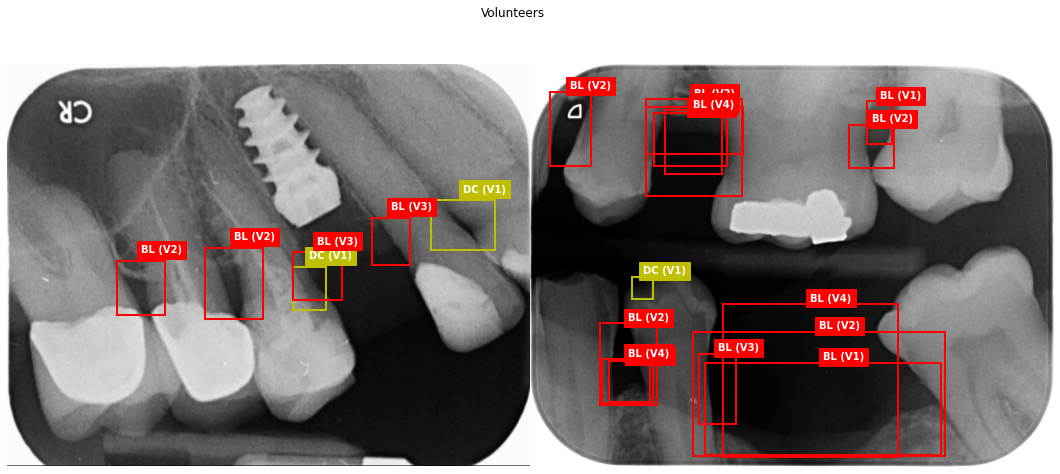

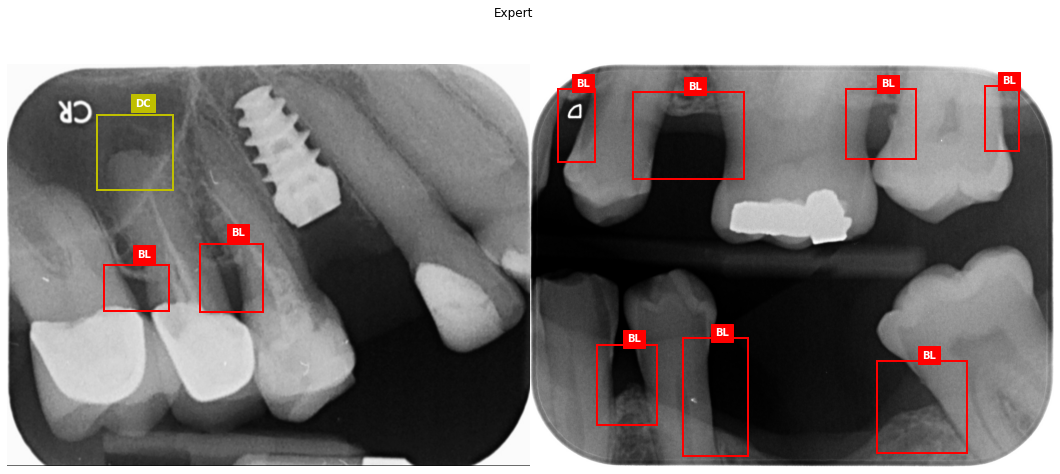

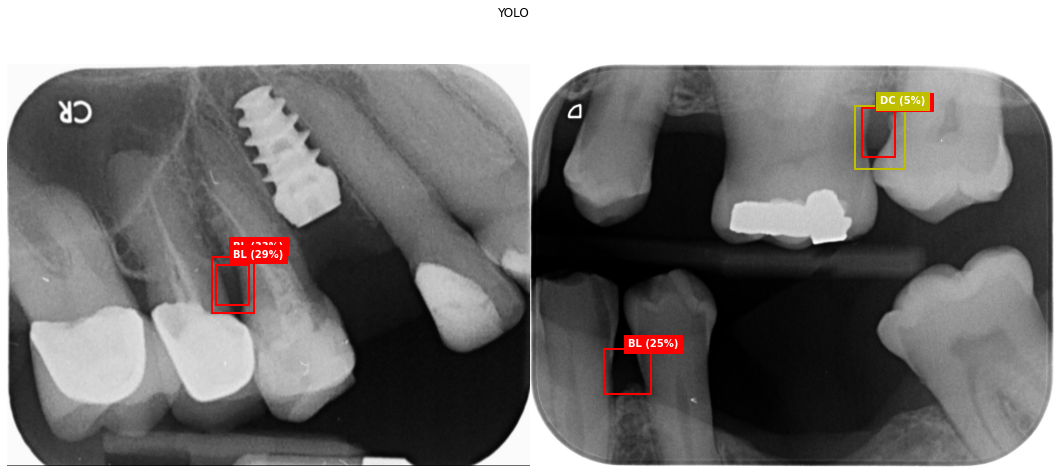

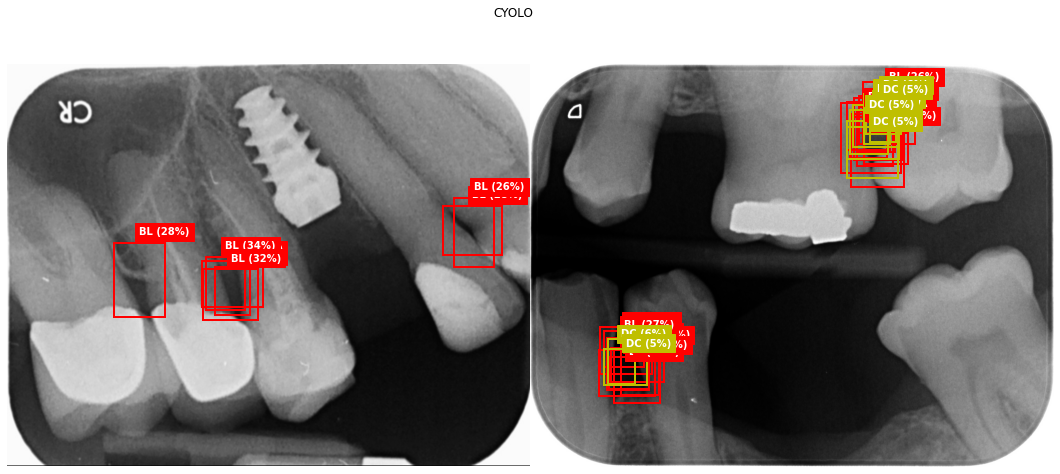

In [92]:
inner_grid = (1, 2)
conf_thres = {'bone-loss': 0.25, 'dental-caries': 0.05}

for m, mode in enumerate(modes):
    fig, axs = plt.subplots(*inner_grid, figsize=(1.25*scale, scale/2))
    # subfigs = fig.subfigures(*outer_grid)
    fig.suptitle(f'{mode_names[mode]}')
    fig.subplots_adjust(wspace=0, hspace=0)
    for innerind, ax in enumerate(axs.flat):
        im_filepath, im_boxes = radiographs_toplot_list[m][innerind]
        plot_predboxes_per_radiograph(im_filepath, im_boxes, ax, conf_thres, mode)